In [7]:
%matplotlib inline

import numpy as np
import networkx as nx
from graph_generator import kronecker_random_graph, P_peri
from cascade import generate_cascade
from matplotlib import pyplot as plt

In [27]:
def run_simulation(k=8, P=P_peri, n_edges=512):
    g = kronecker_random_graph(k, P, directed=False, n_edges=512)
    cascade = generate_cascade(g)
    source = min(cascade, key=lambda k: cascade[k])
    source_inflected_nbrs = list(filter(lambda k: k in cascade, g.neighbors(source)))
    source_uninflected_nbrs = list(filter(lambda k: k not in cascade, g.neighbors(source)))
    return (len(source_inflected_nbrs),
            len(source_uninflected_nbrs),
            len(g.neighbors(source)),
            len(cascade))

In [28]:
from joblib import Parallel, delayed
rows = Parallel(n_jobs=8)(delayed(run_simulation)() for _ in range(int(1e3)))

In [29]:
import pandas as pd
df = pd.DataFrame(rows, columns=['#infected', '#uninfected', 'degree', '#cascade'])

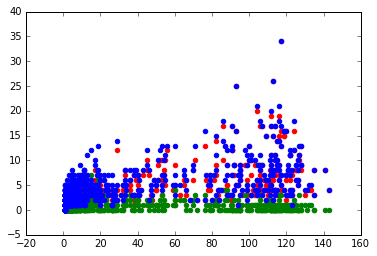

In [30]:
plt.scatter(df['#cascade'], df['#infected'], color='r')
plt.scatter(df['#cascade'], df['#uninfected'], color='g')
plt.scatter(df['#cascade'], df['degree'], color='b')

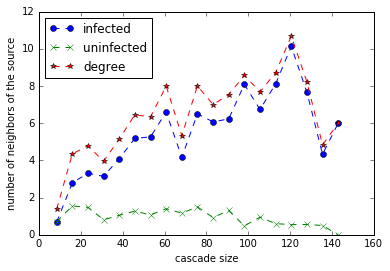

In [37]:
from scipy.stats import binned_statistic
bins = np.linspace(df['#cascade'].min(), df['#cascade'].max(), num=20)
values, bin_edges, _ = binned_statistic(df['#cascade'], df['#infected'], bins=bins, statistic='mean')
plt.plot(bin_edges[1:], values, '--o')


values, bin_edges, _ = binned_statistic(df['#cascade'], df['#uninfected'], bins=bins, statistic='mean')
plt.hold(True)
plt.plot(bin_edges[1:], values, '--x')

values, bin_edges, _ = binned_statistic(df['#cascade'], df['degree'], bins=bins, statistic='mean')
plt.hold(True)
plt.plot(bin_edges[1:], values, '--*')


plt.xlabel('cascade size')
plt.ylabel('number of neighbors of the source')

plt.legend(['infected', 'uninfected', 'degree'], loc='upper left')